## Introduction

Gravitational lensing and image reconstruction are crucial techniques in astrophysics for probing the distribution of mass in the universe, particularly in the study of dark matter and the structure of distant galaxies. Shapelet-based source reconstruction is a powerful method that enables detailed modeling of lensed images, allowing for the exploration of complex astrophysical phenomena.

This project focuses on the application of shapelet decomposition and image simulation using the lenstronomy package, with the goal of reconstructing and simulating lensed images of various astronomical objects. The shapelet method is highly effective due to its ability to represent intricate image structures with a set of orthogonal basis functions, providing a flexible and accurate approach to modeling extended sources.

Central to this project is the decomposition of astronomical images, such as those of galaxies or nebulae, into shapelet coefficients. These coefficients are then utilized to simulate lensing effects, enabling the creation of synthetic lensed images under a variety of conditions. By analyzing different images, we can assess the robustness and versatility of shapelet-based modeling across a range of astrophysical scenarios.

The methodology involves importing and preprocessing images of astronomical objects, followed by their decomposition into shapelet coefficients. These coefficients are used in simulations to produce lensed images, which are then analyzed to gain insights into both the source objects and the lensing potentials. This process leverages several Python libraries, including scipy for image processing, matplotlib for visualization, and lenstronomy for lensing simulations.

The project employs advanced data visualization techniques to present the results, including comparisons of original, convolved, resized, and reconstructed images. These visualizations not only demonstrate the capabilities of shapelet modeling but also provide a comprehensive understanding of the impact of gravitational lensing on different types of astronomical images.

This project contributes to the field of astrophysics by enhancing our ability to model and interpret lensed images, which is essential for studying the mass distribution in the universe. The techniques developed here can be applied to a wide range of astronomical images, offering valuable insights into dark matter, galaxy evolution, and the large-scale structure of the cosmos.

## Required Libraries

To support the image reconstruction and lensing simulation in this project, several Python libraries are utilized, each serving a specific role in the analysis workflow:

- `lenstronomy`: A specialized package for gravitational lensing simulations and modeling, providing essential tools for lensing calculations, image reconstruction, and source modeling.

- `numpy`: A fundamental library for numerical computations in Python, used for handling arrays and performing the mathematical operations necessary for image processing and shapelet decomposition.

- `scipy`: A library that offers functions for scientific computing, including image processing tools such as Gaussian filtering and resolution degradation, which are critical for preparing the data.

- `matplotlib`: A plotting library for creating visualizations, used here to display the original, processed, and simulated images, facilitating the interpretation of the results.

- `imageio`: A library for reading and writing image data, which allows the importation of various astronomical images for analysis.

These libraries work together to enable comprehensive simulation and analysis of gravitational lensing effects, providing the tools necessary for detailed study and visualization of shapelet-based image reconstruction in astrophysics.

11476 number of coefficients


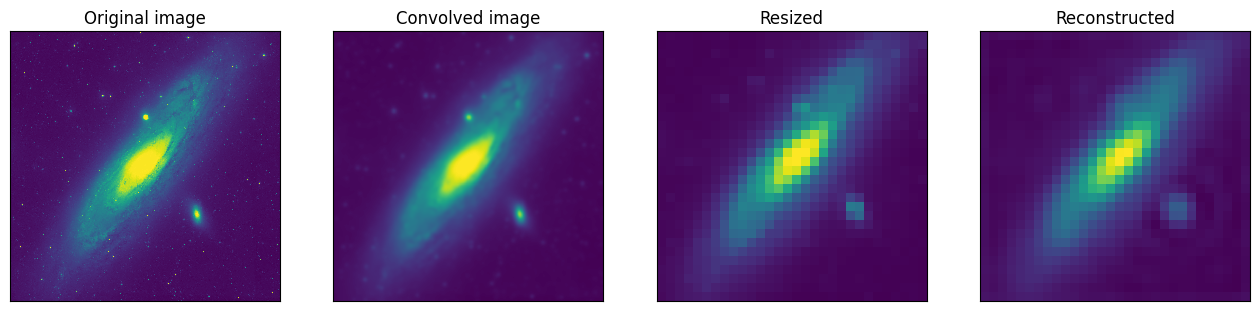

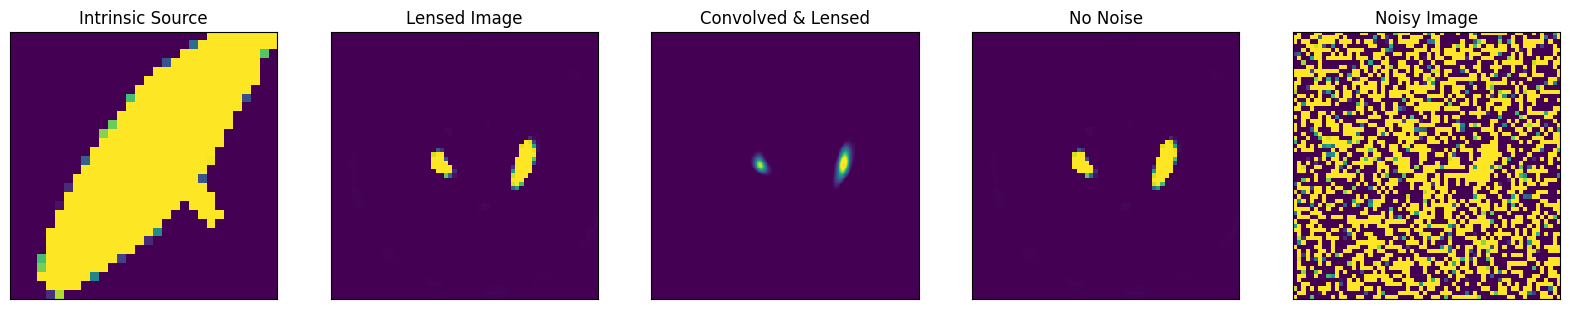

In [1]:
# Perform a basic comparison without a specific deconvolution step

# Standard Python imports
import numpy as np
import os
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.Util import util, image_util
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Util.util import image2array, array2image
from lenstronomy.Util.image_util import add_poisson, add_background
import imageio.v2 as imageio

# Make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# Shapelet Image Decomposition
# Import NGC1300 jpg image and decompose it

# Find path to data
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'C:/Users/szoke/Data/Galaxies/andromeda.png')

# Read data
ngc_data = imageio.imread(ngc_filename, mode='F', pilmode=None)

# Subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# Resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx) / 2.)
y_start = int((n_max - ny) / 2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# Convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = scipy.ndimage.gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# Degrade the pixel resolution by a factor
factor = 25  # Lower resolution of image with a given factor
numPix_large = int(len(ngc_conv) / factor)
n_new = int((numPix_large - 1) * factor)
ngc_cut = ngc_conv[0:n_new, 0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # Make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # Resize image to lower resolution

# Shapelet decomposition
# Turn the image into a single 1D array
image_1d = util.image2array(ngc_data_resized)  # Map 2D image in 1D data array

# Define the shapelet basis set we want the image to decompose in
n_max = 150  # Choice of number of shapelet basis functions, 150 is a high resolution number but takes long
beta = 10  # Shapelet scale parameter (in units of resized pixels)

# Import the ShapeletSet class
shapeletSet = ShapeletSet()

# Decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0)
print(len(coeff_ngc), 'number of coefficients')  # Number of coefficients

# Reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# Turn 1D array back into 2D image
image_reconstructed_2d = util.array2image(image_reconstructed)  # Map 1D data vector in 2D image

# Plot the original, convolved, resized, and reconstructed images
f, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)
ax = axes[0]
ax.matshow(ngc_square, origin='lower')
ax.set_title("Original image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
ax.matshow(ngc_conv, origin='lower')
ax.set_title("Convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
ax.matshow(ngc_data_resized, origin='lower')
ax.set_title("Resized")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
ax.matshow(image_reconstructed_2d, origin='lower')
ax.set_title("Reconstructed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# Simulation Illustration with lenstronomy
# Define data specifics
background_rms = 10.0  # Background noise per pixel
exp_time = 100.0  # Exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  # Cutout pixel size
deltaPix = 0.05  # Pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor  # Set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1  # Full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'

# Define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2.0, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# Define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.0

# Define the source size (effectively the Shapelet scale parameter)
beta_model = 0.06
# Use the shapelet coefficients decomposed from NGC1300
coeff = coeff_ngc / deltaPix**2
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': coeff, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_source = [kwargs_shapelet]

# For this example, we do not include deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

# Setup the different Data and PSF classes to perform and return the output at various stages of the computation
kwargs_data_real = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_real = ImageData(**kwargs_data_real)

kwargs_data_high_res = sim_util.data_configure_simple(numPix * high_res_factor, deltaPix / high_res_factor, exp_time, background_rms)
data_high_res = ImageData(**kwargs_data_high_res)

psf = PSF(psf_type=psf_type, fwhm=fwhm, truncation=5)
psf_high_res = psf
psf_no = PSF(psf_type='NONE')

# Compute the images
imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics={'supersampling_factor': subgrid_res, 'supersampling_convolution': True}, lens_model_class=LensModel(lens_model_list), source_model_class=LightModel(source_model_list))
image_no_noise_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None)

poisson = add_poisson(image_no_noise_lensed, exp_time=exp_time)
bkg = add_background(image_no_noise_lensed, sigma_bkd=background_rms)
image_real_lensed = image_no_noise_lensed + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_high_res, lens_model_class=LensModel(lens_model_list), source_model_class=LightModel(source_model_list))
image_high_res_conv_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

# Display simulation results
f, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
ax.matshow(ngc_data_resized, origin='lower', vmin=0, vmax=2)
ax.set_title("Intrinsic Source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
ax.matshow(image_no_noise_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Lensed Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
ax.matshow(image_high_res_conv_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Convolved & Lensed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
ax.matshow(image_no_noise_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("No Noise")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[4]
ax.matshow(image_real_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Noisy Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()


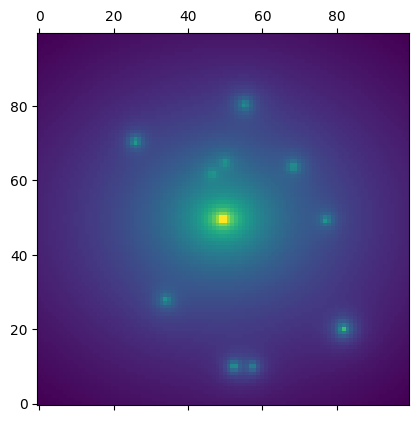

In [3]:
# define the lens model of the main deflector
main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list = [kwargs_lens_main, kwargs_shear]

subhalo_type = 'TNFW'  # We chose spherical NFW profiles, feel free to chose whatever you want.

# as an example, we render some sub-halos with a very simple distribution to be added on the main lens
num_subhalo = 10  # number of subhalos to be rendered
# the parameterization of the NFW profiles are:
# - Rs (radius of the scale parameter Rs in units of angles)
# - theta_Rs (radial deflection angle at Rs)
# - center_x, center_y, (position of the centre of the profile in angular units)

Rs_mean = 0.1
Rs_sigma = 0.1  # dex scatter
theta_Rs_mean = 0.05
theta_Rs_sigma = 0.1 # dex scatter
r_min, r_max = -2, 2

Rs_list = 10**(np.log10(Rs_mean) + np.random.normal(loc=0, scale=Rs_sigma, size=num_subhalo))
theta_Rs_list = 10**(np.log10(theta_Rs_mean) + np.random.normal(loc=0, scale=theta_Rs_sigma, size=num_subhalo))
center_x_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
center_y_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
for i in range(num_subhalo):
    lens_model_list.append(subhalo_type)
    kwargs_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
                             'center_x': center_x_list[i], 'center_y': center_y_list[i],
                            'r_trunc': 5*Rs_list[i]
                            })

# now we define a LensModel class of all the lens models combined
from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)
# we set up a grid in coordinates and evaluate basic lensing quantities on it
x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.05)
kappa = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)
# we make a 2d array out of the 1d grid points
kappa = util.array2image(kappa)
# and plot the convergence of the lens model
plt.matshow(np.log10(kappa), origin='lower')
plt.show()

In [5]:
z_lens = 0.5
z_source = 2
from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# class that converts angular to physical units for a specific cosmology and redshift configuration
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# here we turn an NFW halo defined as M200 crit and concentration into lensing quantities
M200 = 10**9
concentration = 6
Rs_angle_clump, theta_Rs_clump = lensCosmo.nfw_physical2angle(M=M200, c=concentration)
print(Rs_angle_clump, theta_Rs_clump)

# and here we do the oposite and turn the lensing quantities into physical units
rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump = lensCosmo.nfw_angle2physical(Rs_angle_clump, theta_Rs_clump)
print(rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump)

0.46485575154335124 0.0024104877548606738
2922417084656602.0 0.0029244057159433894 6.0000032204516405 0.017546443713567523 1000001610.2266853


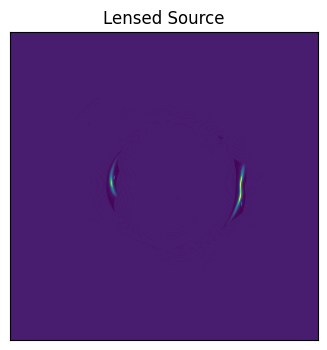

In [7]:
# Assuming lensModel and kwargs_lens_list are defined elsewhere
# Define parameters for high-resolution grid
numPix = 100  # Number of pixels (low resolution of data)
deltaPix = 0.05  # Pixel size (low resolution of data)
high_res_factor = 3  # Higher resolution factor (per axis)

# Create high-resolution grid
theta_x_high_res, theta_y_high_res = util.make_grid(numPix=numPix * high_res_factor, deltapix=deltaPix / high_res_factor)

# Ray-shoot the image plane coordinates (angles) to the source plane (angles)
beta_x_high_res, beta_y_high_res = lensModel.ray_shooting(theta_x_high_res, theta_y_high_res, kwargs=kwargs_lens_list)

# Define parameters for shapelet functions on the source plane
beta_source = 0.05  # Width of the shapelets (Gaussian width)
center_x = 0.2  # Center x position for shapelets on the source plane
center_y = 0.0  # Center y position for shapelets on the source plane

# Evaluate shapelet functions in the new coordinate system of the source plane
source_lensed = shapeletSet.function(beta_x_high_res, beta_y_high_res, coeff_ngc, n_max, beta=beta_source, center_x=center_x, center_y=center_y)

# Convert 1D vector back into a 2D array
source_lensed_2d = util.array2image(source_lensed)

# Plot the lensed source
f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
ax.imshow(source_lensed_2d, origin='lower')
ax.set_title("Lensed Source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

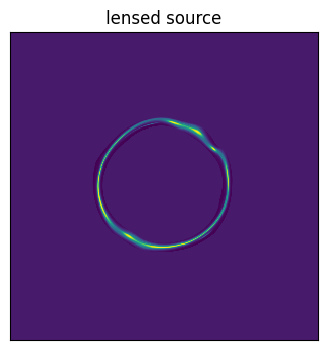

In [9]:
# here we perform the surface brightness computation with an interpolation function instead of the shapelets decomposition
# for high orders, this may be computationally more effective
kwargs_interp = {'image': ngc_data_resized, 'center_x': 0, 'center_y': 0, 'scale': 0.005, 'phi_G':0.2}
from lenstronomy.LightModel.Profiles.interpolation import Interpol
interp_light = Interpol()


source_lensed_interp = interp_light.function(beta_x_high_res, beta_y_high_res, **kwargs_interp)
# and turn the 1d vector back into a 2d array
source_lensed_interp = util.array2image(source_lensed_interp)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed_interp, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

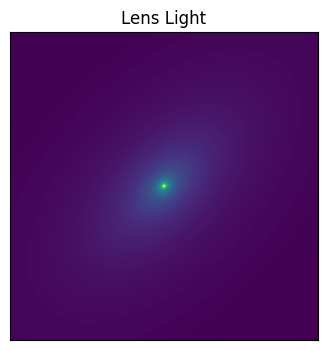

Dimensions of source_lensed: (300, 300)
Dimensions of flux_lens_light: (300, 300)


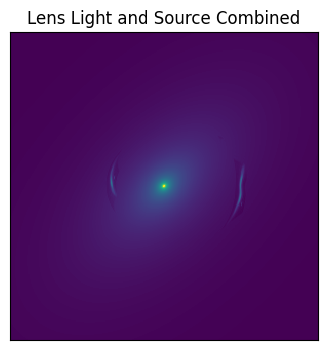

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LightModel.light_model import LightModel
from skimage.transform import resize

# Define the lens light profile using Sersic profiles
light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
kwargs_lens_light = [
    {'amp': 20, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
    {'amp': 30, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
]
lensLightModel = LightModel(light_model_list=light_model_list)

# Evaluate the surface brightness of the unlensed coordinates
flux_lens_light = lensLightModel.surface_brightness(theta_x_high_res, theta_y_high_res, kwargs_lens_light)
flux_lens_light = util.array2image(flux_lens_light)

# Plot the lens light profile
f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
ax.matshow(flux_lens_light, origin='lower')
ax.set_title("Lens Light")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# Ensure source_lensed is in 2D format
if len(source_lensed.shape) == 1:
    # Reshape source_lensed to 2D if necessary
    source_lensed = util.array2image(source_lensed)

# Check dimensions
print(f"Dimensions of source_lensed: {source_lensed.shape}")
print(f"Dimensions of flux_lens_light: {flux_lens_light.shape}")

# Ensure both images have the same dimensions
if source_lensed.shape != flux_lens_light.shape:
    # Resize source_lensed to match flux_lens_light dimensions
    source_lensed = resize(source_lensed, flux_lens_light.shape, mode='reflect')

# Combine the lensed source with the lens light profile
image_combined = source_lensed + flux_lens_light

# Plot the combined image
f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
ax.matshow(image_combined, origin='lower')
ax.set_title("Lens Light and Source Combined")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()


In [13]:
# import of standard python libraries and the required lenstronomy modules
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

np.random.seed(41)

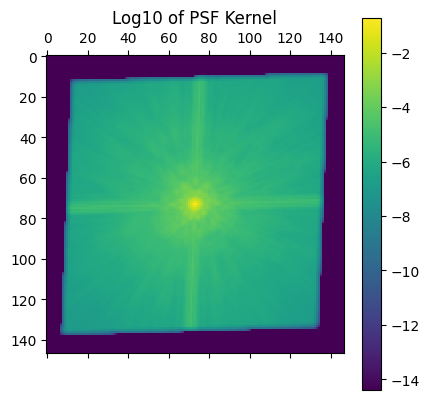

In [33]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
from astropy.cosmology import LambdaCDM
from lenstronomy.Util import kernel_util, simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# Define lens configuration and cosmology
z_lens = 0.5
z_source = 1.5
# Parameters for a closed universe (Ω0 > 1)
H0 = 70  # Hubble constant at z = 0 in km/s/Mpc
Om0 = 0.35  # Omega matter: density parameter for matter (dark + baryonic) at z = 0
Ode0 = 0.75  # Omega dark energy: density parameter for dark energy at z = 0

# Calculating Omega_k for a closed universe where Ω0 = 1.2 (as an example)
Omega0 = 1.2

# Instantiate the LambdaCDM cosmology
cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0)

# Import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'C:/Users/szoke/Data/Galaxies/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

# Handle zero values in kernel for logarithm
kernel[kernel <= 0] = np.min(kernel[kernel > 0]) / 10  # Replace zeros with a small positive value

# Display the PSF kernel
plt.matshow(np.log10(kernel))
plt.colorbar()
plt.title("Log10 of PSF Kernel")
plt.show()

# Data specifics
background_rms = 0.2  # Background noise per pixel (Gaussian RMS value)
exp_time = 80.0  # Exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  # Cutout pixel size
deltaPix = 0.05  # Pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # Full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required)

# Generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

# Generate the PSF variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)


C:\Users\szoke\AppData\Local\Temp\ipykernel_11376\195860676.py:60: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


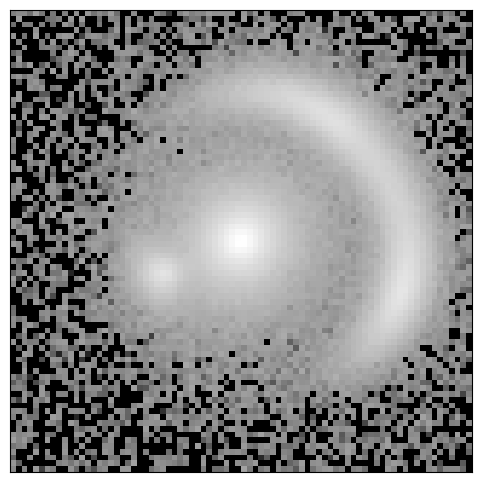

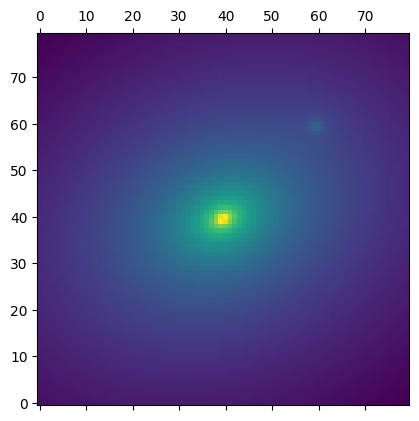

In [27]:
# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0.3
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and here we compute the convergence at each pixel position
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.show()

In [70]:
# First we only model the macro-model
lens_model_simple_list = ['EPL', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0., 'e2': 0.})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                    }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, []]


mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.3728139269493458 reduced X^2 of best position
-4377.903613041463 log likelihood
6378 effective number of data points
[{'theta_E': 1.15877424705001, 'gamma': 2.0552404602373335, 'e1': 0.08291704783410848, 'e2': 0.09971491673299639, 'center_x': 0.006919080291401583, 'center_y': 0.014099054611118303}, {'gamma1': -0.02035571065567936, 'gamma2': -0.07941884523691438, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10715341904457654, 'n_sersic': 1.0001303998846205, 'e1': 0.06691842241104988, 'e2': 0.16131233114616836, 'center_x': 0.3346154227125656, 'center_y': 0.12519151607930812}] source result
[{'amp': 1, 'R_sersic': 0.20032378351629312, 'n_sersic': 2.101706040001737, 'e1': -0.019856459880482843, 'e2': 0.06384332826243079, 'center_x': -0.00040154218370029083, 'center_y': 0.0001006218979783616}] lens light result
[] point source result
[] tracer source result
{} special param result
72.30

-1.3680948790754572 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3680948790754572


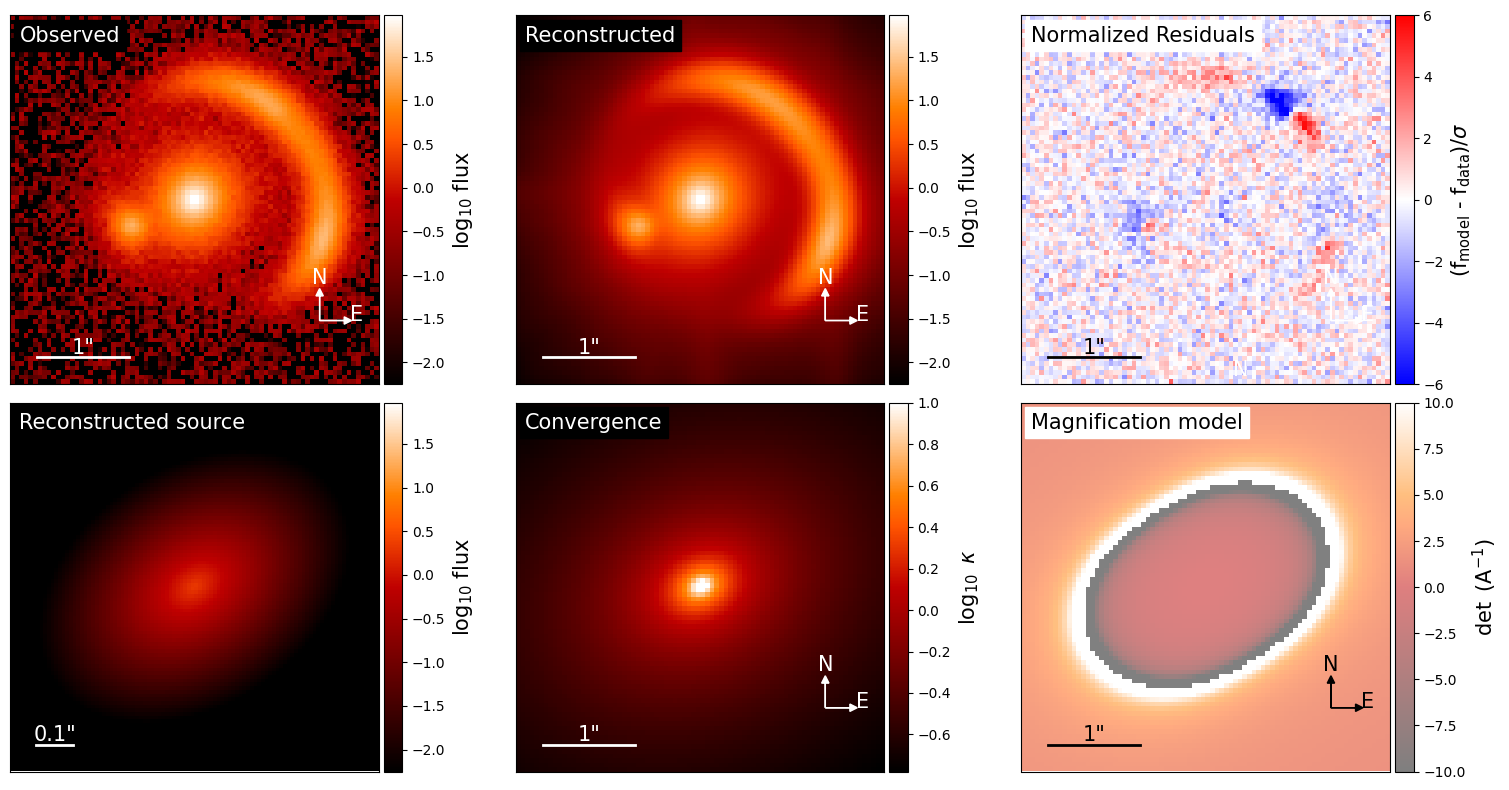

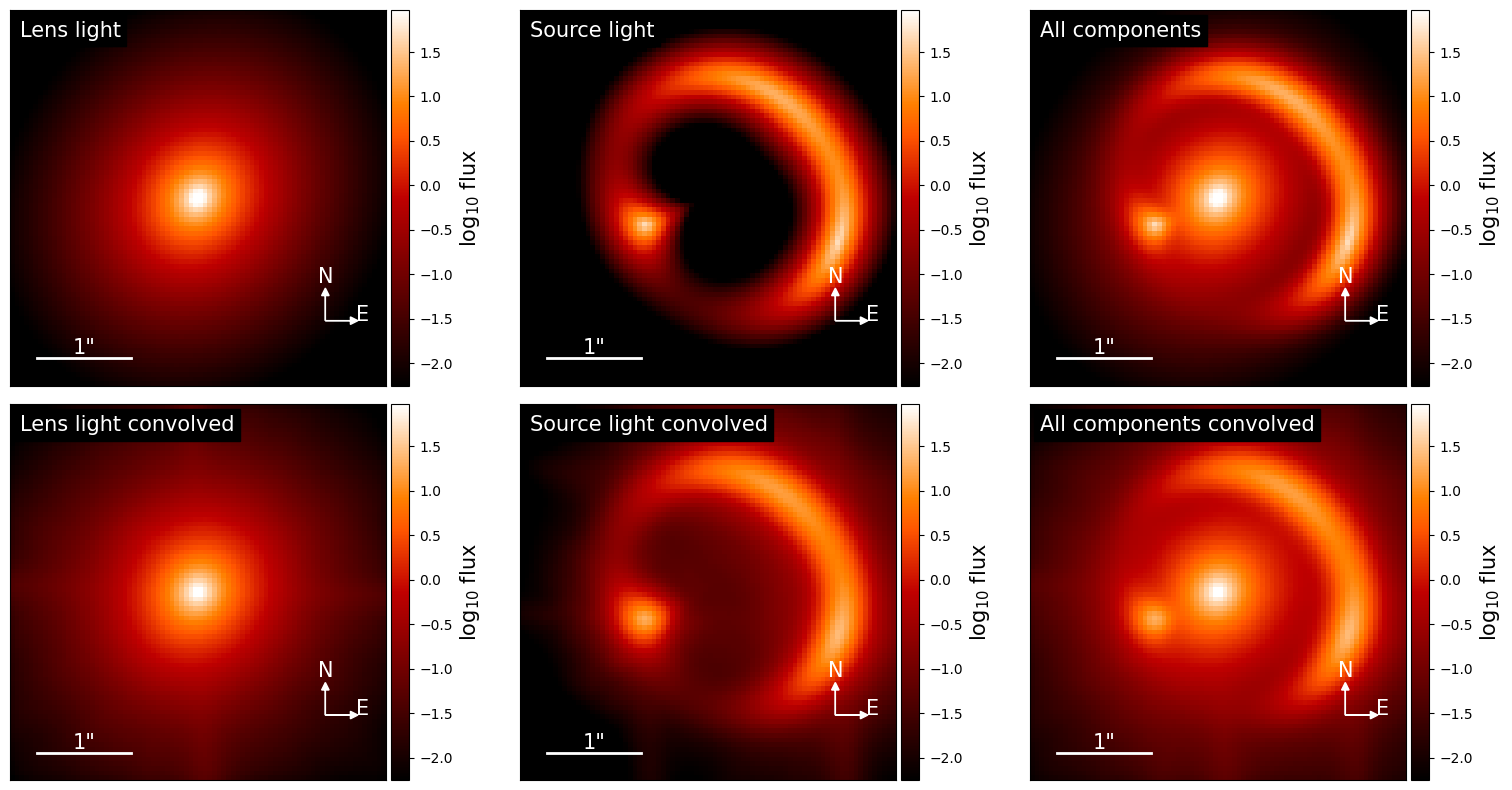

{'kwargs_lens': [{'theta_E': 1.15877424705001, 'gamma': 2.0552404602373335, 'e1': 0.08291704783410848, 'e2': 0.09971491673299639, 'center_x': 0.006919080291401583, 'center_y': 0.014099054611118303}, {'gamma1': -0.02035571065567936, 'gamma2': -0.07941884523691438, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 4259.672195015752, 'R_sersic': 0.10715341904457654, 'n_sersic': 1.0001303998846205, 'e1': 0.06691842241104988, 'e2': 0.16131233114616836, 'center_x': 0.3346154227125656, 'center_y': 0.12519151607930812}], 'kwargs_lens_light': [{'amp': 7858.360037439125, 'R_sersic': 0.20032378351629312, 'n_sersic': 2.101706040001737, 'e1': -0.019856459880482843, 'e2': 0.06384332826243079, 'center_x': -0.00040154218370029083, 'center_y': 0.0001006218979783616}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


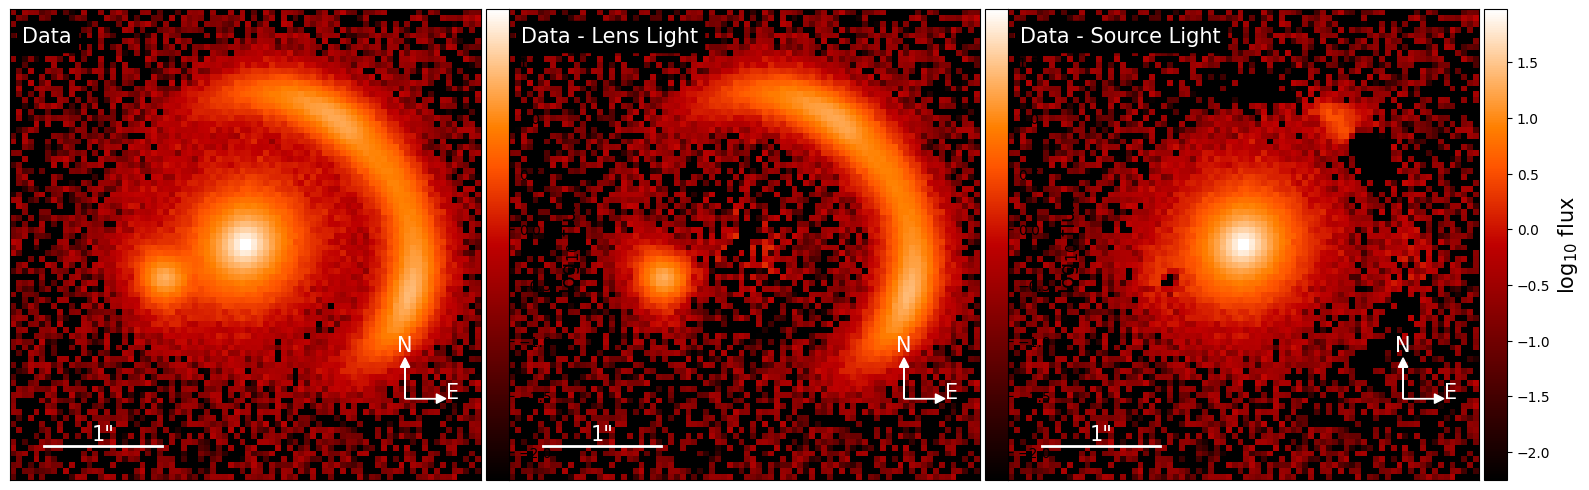

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Plots.model_plot import ModelPlot

# Assuming `multi_band_list`, `kwargs_model`, and `kwargs_result` are already defined

# Initialize ModelPlot
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Subplot for various plots
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

# Data Plot
modelPlot.data_plot(ax=axes[0, 0])

# Model Plot
modelPlot.model_plot(ax=axes[0, 1])

# Normalized Residuals Plot
modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-6, v_max=6)

# Source Plot
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)

# Convergence Plot
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)

# Magnification Plot
modelPlot.magnification_plot(ax=axes[1, 2])

# Adjust layout
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

# Decomposition Plots
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0, 0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0, 1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0, 2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1, 2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

# Adjust layout
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

# Print the results
print(kwargs_result)

# Subtraction plots
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)

# Adjust layout
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


In [81]:
# add substructure

lens_model_substructure_list = ['EPL', 'SHEAR', 'NFW']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.01, 'Rs': 0.05, 'center_x': 3, 'center_y': 3})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -3, 'center_y': -3})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 3, 'center_y': 3})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 800, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0511895720085926 reduced X^2 of best position
-3350.1411659913847 log likelihood
6374 effective number of data points
[{'theta_E': 1.1514514484227025, 'gamma': 2.0659552346720895, 'e1': 0.09494435745440857, 'e2': 0.09057387566000304, 'center_x': 0.01098170281145689, 'center_y': 0.006309140253626792}, {'gamma1': -0.014308802543721511, 'gamma2': -0.07294941117373463, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.10944867684040947, 'alpha_Rs': 0.021862795901449256, 'center_x': 0.9873448431778321, 'center_y': 0.9821456674035253}] lens result
[{'amp': 1, 'R_sersic': 0.11038621169212126, 'n_sersic': 0.9963911474639732, 'e1': 0.06428236780715274, 'e2': 0.11565016052459962, 'center_x': 0.3416243515997754, 'center_y': 0.11800732966451326}] source result
[{'amp': 1, 'R_sersic': 0.20067298783947238, 'n_sersic': 2.019683921613389, 'e1': -0.010303618868730666, 'e2': 0.05642185381346541, 'center_x': -7.111254974036908e-05, '

-1.0469191143723078 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0469191143723078


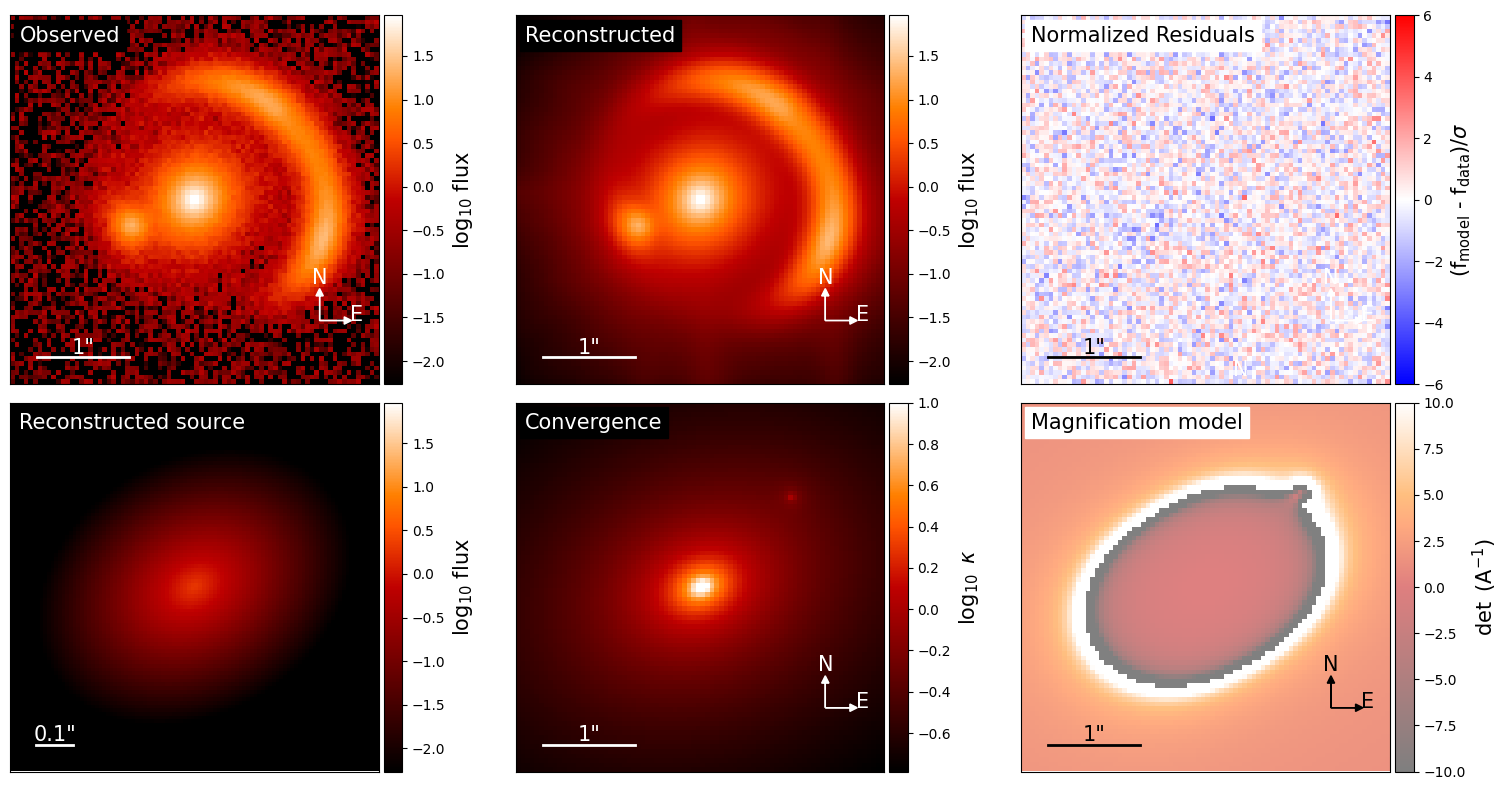

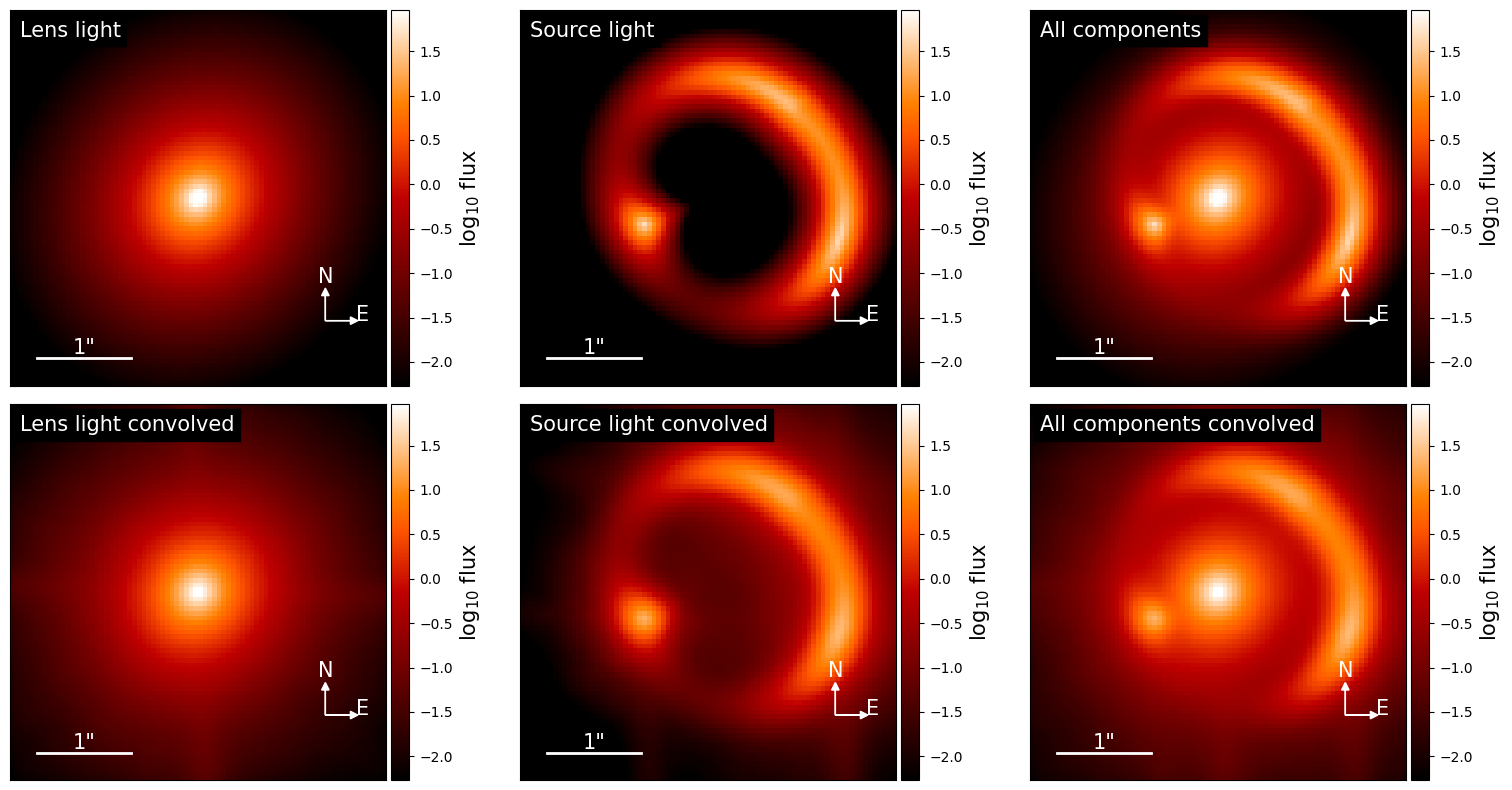

{'kwargs_lens': [{'theta_E': 1.1514514484227025, 'gamma': 2.0659552346720895, 'e1': 0.09494435745440857, 'e2': 0.09057387566000304, 'center_x': 0.01098170281145689, 'center_y': 0.006309140253626792}, {'gamma1': -0.014308802543721511, 'gamma2': -0.07294941117373463, 'ra_0': 0, 'dec_0': 0}, {'Rs': 0.10944867684040947, 'alpha_Rs': 0.021862795901449256, 'center_x': 0.9873448431778321, 'center_y': 0.9821456674035253}], 'kwargs_source': [{'amp': 4015.583746847533, 'R_sersic': 0.11038621169212126, 'n_sersic': 0.9963911474639732, 'e1': 0.06428236780715274, 'e2': 0.11565016052459962, 'center_x': 0.3416243515997754, 'center_y': 0.11800732966451326}], 'kwargs_lens_light': [{'amp': 7930.661116977525, 'R_sersic': 0.20067298783947238, 'n_sersic': 2.019683921613389, 'e1': -0.010303618868730666, 'e2': 0.05642185381346541, 'center_x': -7.111254974036908e-05, 'center_y': -0.0004190194192941001}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


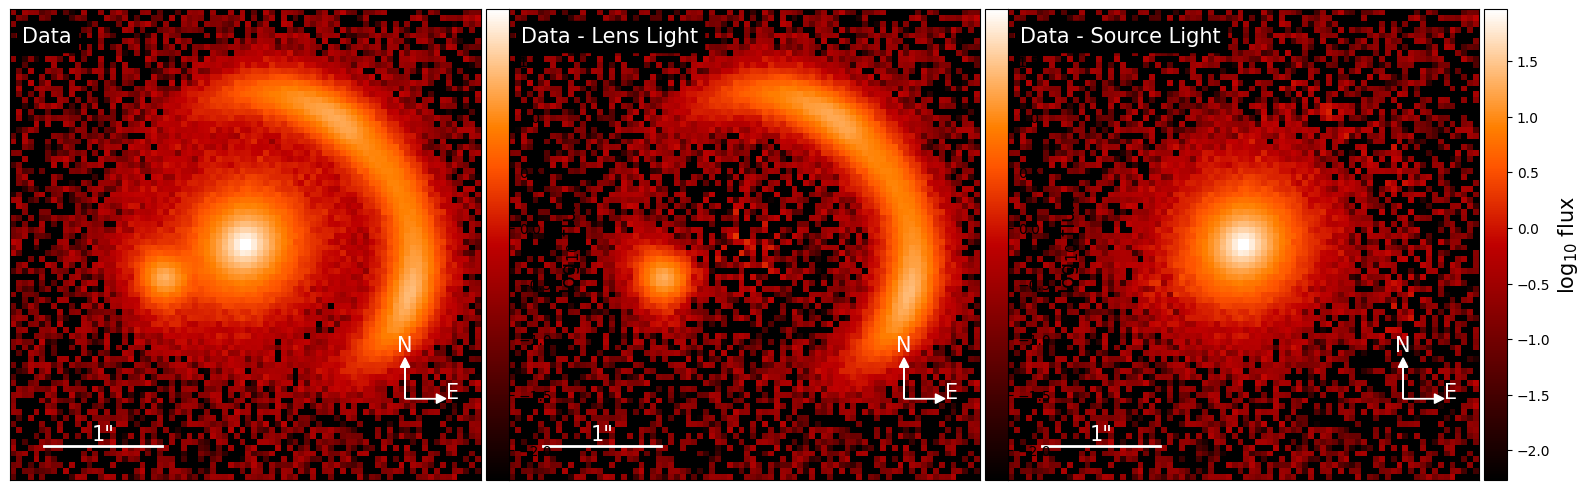

In [82]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [83]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][2])
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': 1., 'Rs': 2, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 6, 'sigma_scale': 0.1}]]
start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

MCMC selected. Sampling with default option emcee.


100%|██████████| 400/400 [07:47<00:00,  1.17s/it]

Computing the MCMC...
Number of walkers =  144
Burn-in iterations:  200
Sampling iterations (in current run): 400
468.56097316741943 time taken for MCMC sampling
468.9621841907501 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


number of non-linear parameters in the MCMC process:  24
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'Rs_lens2', 'alpha_Rs_lens2', 'center_x_lens2', 'center_y_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  28800


C:\Users\szoke\AppData\Local\Temp\ipykernel_19592\3481826808.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


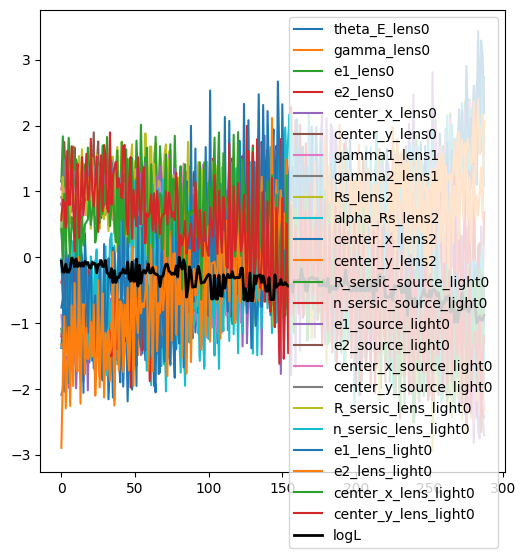

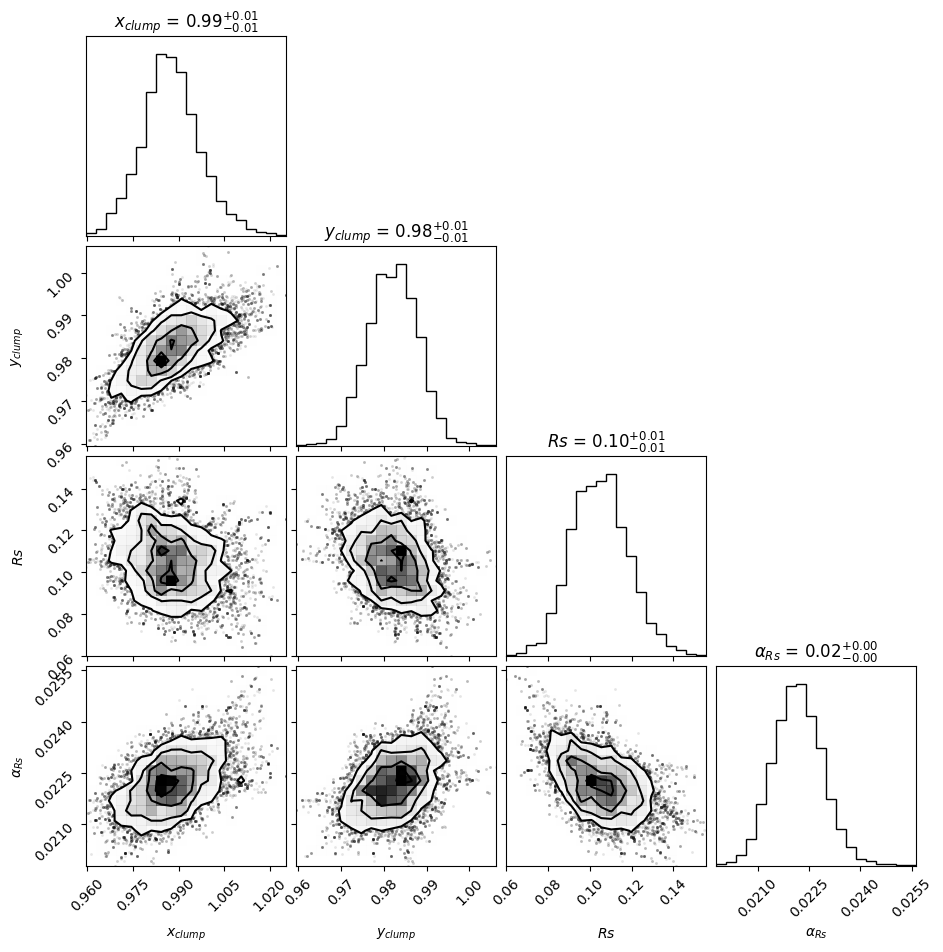

In [84]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$x_{clump}$", r"$y_{clump}$", r"$Rs$", r"$\alpha_{Rs}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    mcmc_new_list.append([kwargs_result['kwargs_lens'][2]['center_x'], 
                          kwargs_result['kwargs_lens'][2]['center_y'], 
                          kwargs_result['kwargs_lens'][2]['Rs'], 
                          kwargs_result['kwargs_lens'][2]['alpha_Rs']])

fig = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
fig.show()

## References

[1] https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/DMSubstructure/substructure_challenge_mock_production.ipynb